In [89]:
from PIL import Image
import numpy as np
import cv2
import time 

In [109]:
# Read image 
image = cv2.imread('dahlia.png')

# Validate image format
N, M, D = np.int32(image.shape)

In [110]:
S = np.float32(image) / 256

# Compute image OTF
size_2D = [N, M]
fx = np.int32([[1, -1]])
fy = np.int32([[1], [-1]])

In [111]:
(N, M)

(480, 640)

In [112]:
def psf2otf(psf, outSize):
    
    psf = np.float32(psf)

    # Determine PSF / OTF shapes
    psfSize = np.int32(psf.shape)

    # Pad the PSF to outSize
    new_psf = np.zeros(outSize, dtype=np.float32)
    
    
    
    new_psf[:psfSize[0],:psfSize[1]] = psf[:,:]
    psf = new_psf
    
    print(new_psf.shape)

    # Circularly shift the OTF so that PSF center is at (0,0)
    shift = -(psfSize / 2)
    
    for i in range(shift.size):
        psf = np.roll(psf, int(shift[i]), axis=i)
    
    otf = np.fft.fftn(psf)
    return otf

In [113]:
otfFx = psf2otf(fx, size_2D)
otfFy = psf2otf(fy, size_2D)

(480, 640)
(480, 640)


In [114]:
# otfFx

In [115]:
# otfFy

In [116]:
# otfFy

In [117]:
_lambda = 2e-2
kappa = 2.0

# Compute F(I)
# create tensor for each 
FI = np.complex64(np.zeros((N, M, D)))
for i in range(S.shape[2]):
    FI[:,:,i] = np.fft.fft2(S[:,:,i])

In [118]:
FI[:,:,0]

array([[83713.31       +0.j     , -1685.369  +23788.664j  ,
        -3003.2825 +11784.816j  , ...,   664.86163 -7530.953j  ,
        -3003.2825 -11784.816j  , -1685.369  -23788.664j  ],
       [-5860.287   +4357.075j  , -4246.231   -2464.7407j ,
         5392.1357  +1677.4004j , ...,  -283.1191   -514.38j   ,
         4878.217   +1430.506j  ,  1825.1383  -4165.947j  ],
       [  574.70917 -1438.3572j ,  1099.3495  +4323.981j  ,
         -632.68286 +1763.2448j , ..., -1815.4269  -2690.1663j ,
         1218.613   -1474.764j  ,  5548.7617  +1816.7279j ],
       ...,
       [ 1992.0261  -1807.2662j ,  4007.7983   -347.39236j,
          275.71472 +3579.3857j , ..., -1949.7848  +1568.3726j ,
        -1443.0964   -616.866j  ,  -544.0307  -2523.4382j ],
       [  574.70917 +1438.3572j ,  5548.7617  -1816.7279j ,
         1218.613   +1474.764j  , ..., -1094.0167  +1241.015j  ,
         -632.68286 -1763.2448j ,  1099.3495  -4323.981j  ],
       [-5860.287   -4357.075j  ,  1825.1383  +4165.947j  

In [120]:
# Compute MTF
MTF = np.power(np.abs(otfFx), 2) + np.power(np.abs(otfFy), 2)
MTF = np.tile(MTF[:, :, np.newaxis], (1, 1, D))

# Initialize buffers
h = np.float32(np.zeros((N, M, D)))
v = np.float32(np.zeros((N, M, D)))
dxhp = np.float32(np.zeros((N, M, D)))
dyvp = np.float32(np.zeros((N, M, D)))
FS = np.complex64(np.zeros((N, M, D)))

# Iteration settings
beta_max = 1e5;
beta = 2 * _lambda
iteration = 0

# Iterate until desired convergence in similarity
while beta < beta_max:

    # compute dxSp
    h[:,0:M-1,:] = np.diff(S, 1, 1)
    h[:,M-1:M,:] = S[:,0:1,:] - S[:,M-1:M,:]

    # compute dySp
    v[0:N-1,:,:] = np.diff(S, 1, 0)
    v[N-1:N,:,:] = S[0:1,:,:] - S[N-1:N,:,:]

    # compute minimum energy E = dxSp^2 + dySp^2 <= _lambda/beta
    r = np.sum(np.power(h, 2) + np.power(v, 2), axis=2) 
    t = r < _lambda / beta
    
    print(r)
    t = np.tile(t[:, :, np.newaxis], (1, 1, 3))

    # compute piecewise solution for hp, vp
    h[t] = 0
    v[t] = 0

    # compute dxhp + dyvp
    dxhp[:,0:1,:] = h[:,M-1:M,:] - h[:,0:1,:]
    dxhp[:,1:M,:] = -(np.diff(h, 1, 1))
    dyvp[0:1,:,:] = v[N-1:N,:,:] - v[0:1,:,:]
    dyvp[1:N,:,:] = -(np.diff(v, 1, 0))
    normin = dxhp + dyvp

    
    FS[:,:,0] = np.fft.fft2(normin[:,:,0])
    FS[:,:,1] = np.fft.fft2(normin[:,:,1])
    FS[:,:,2] = np.fft.fft2(normin[:,:,2])
    
    # solve for S + 1 in Fourier domain
    denorm = 1 + beta * MTF;
    FS[:,:,:] = (FI + beta * FS) / denorm
    
    print(denorm)

    # inverse FFT to compute S + 1
    S[:,:,0] = np.float32((np.fft.ifft2(FS[:,:,0])).real)
    S[:,:,1] = np.float32((np.fft.ifft2(FS[:,:,1])).real)
    S[:,:,2] = np.float32((np.fft.ifft2(FS[:,:,2])).real)

    # update beta for next iteration
    beta *= kappa
    iteration += 1

# Rescale image
S = S * 256

print("Iterations: %d" % (iteration))

cv2.imwrite('out.png', S)

[[5.61711788e-02 3.48244421e-02 5.98688377e-03 ... 4.41313446e-01
  5.69713712e-01 2.35787227e+04]
 [1.21814743e-01 1.76168587e-02 1.12483315e-02 ... 3.79486680e-01
  1.03086185e+00 2.35977734e+04]
 [1.27325624e-01 3.42094228e-02 2.63435692e-02 ... 2.16884464e-01
  5.01631141e-01 2.34324062e+04]
 ...
 [1.02161197e-02 9.49992239e-03 7.96575472e-03 ... 1.98846608e-01
  1.91000385e+01 6.82683281e+04]
 [1.71609391e-02 1.36727095e-02 9.96604003e-03 ... 9.85490513e+00
  2.19797630e+01 6.96760078e+04]
 [3.29876393e-02 2.74687149e-02 5.39106363e-03 ... 1.16288906e+04
  1.20756328e+04 8.31378906e+04]]
[[[1.         1.         1.        ]
  [1.00000386 1.00000386 1.00000386]
  [1.00001542 1.00001542 1.00001542]
  ...
  [1.0000347  1.0000347  1.0000347 ]
  [1.00001542 1.00001542 1.00001542]
  [1.00000386 1.00000386 1.00000386]]

 [[1.00000685 1.00000685 1.00000685]
  [1.00001071 1.00001071 1.00001071]
  [1.00002227 1.00002227 1.00002227]
  ...
  [1.00004155 1.00004155 1.00004155]
  [1.00002227 1.

[[[1.         1.         1.        ]
  [1.00006168 1.00006168 1.00006168]
  [1.00024673 1.00024673 1.00024673]
  ...
  [1.00055513 1.00055513 1.00055513]
  [1.00024673 1.00024673 1.00024673]
  [1.00006168 1.00006168 1.00006168]]

 [[1.00010966 1.00010966 1.00010966]
  [1.00017135 1.00017135 1.00017135]
  [1.00035639 1.00035639 1.00035639]
  ...
  [1.00066479 1.00066479 1.00066479]
  [1.00035639 1.00035639 1.00035639]
  [1.00017135 1.00017135 1.00017135]]

 [[1.00043862 1.00043862 1.00043862]
  [1.00050031 1.00050031 1.00050031]
  [1.00068536 1.00068536 1.00068536]
  ...
  [1.00099375 1.00099375 1.00099375]
  [1.00068536 1.00068536 1.00068536]
  [1.00050031 1.00050031 1.00050031]]

 ...

 [[1.00098683 1.00098683 1.00098683]
  [1.00104852 1.00104852 1.00104852]
  [1.00123357 1.00123357 1.00123357]
  ...
  [1.00154196 1.00154196 1.00154196]
  [1.00123357 1.00123357 1.00123357]
  [1.00104852 1.00104852 1.00104852]]

 [[1.00043862 1.00043862 1.00043862]
  [1.00050031 1.00050031 1.00050031]


[[1.9668533e-02 1.2196288e-05 6.8116483e-06 ... 2.2727196e-04
  3.8338262e-03 2.9826894e-01]
 [1.2433917e-02 1.2432263e-05 8.6644268e-06 ... 1.1252030e-04
  2.1619812e-02 7.2870696e-01]
 [9.1907158e-03 1.3661453e-05 1.0553465e-05 ... 3.3077005e-05
  7.9473518e-03 5.8343649e-01]
 ...
 [3.5712861e-02 6.1702020e-05 7.8100547e-06 ... 8.2444418e-03
  4.7321118e-02 1.8147950e+00]
 [5.0242167e-02 7.4231299e-04 1.7321501e-06 ... 1.8551592e-02
  4.5223117e-02 1.7492661e+00]
 [2.2201002e-01 2.7503960e-03 5.8676578e-06 ... 3.2136208e-01
  3.2989588e-01 3.4825120e+00]]
[[[1.         1.         1.        ]
  [1.00789562 1.00789562 1.00789562]
  [1.03158172 1.03158172 1.03158172]
  ...
  [1.07105602 1.07105602 1.07105602]
  [1.03158172 1.03158172 1.03158172]
  [1.00789562 1.00789562 1.00789562]]

 [[1.01403657 1.01403657 1.01403657]
  [1.02193219 1.02193219 1.02193219]
  [1.04561829 1.04561829 1.04561829]
  ...
  [1.08509259 1.08509259 1.08509259]
  [1.04561829 1.04561829 1.04561829]
  [1.02193219 1

[[1.9810885e-02 4.6348217e-07 4.0097987e-07 ... 2.4297278e-04
  3.5254287e-03 2.9535526e-01]
 [1.2707917e-02 4.5658217e-07 3.7818845e-07 ... 3.1623515e-06
  2.2653094e-02 7.2276103e-01]
 [9.2127901e-03 4.0070262e-07 3.5358130e-07 ... 7.3867532e-06
  7.4245608e-03 5.8107817e-01]
 ...
 [3.5497740e-02 7.0116221e-06 3.6313688e-07 ... 7.4952566e-03
  4.7502693e-02 1.8067534e+00]
 [4.8299290e-02 9.2358084e-04 3.6443600e-07 ... 1.8232208e-02
  4.5474347e-02 1.7436490e+00]
 [2.2177161e-01 2.2273476e-03 5.6129602e-07 ... 3.1263977e-01
  3.2635164e-01 3.4644592e+00]]
[[[1.         1.         1.        ]
  [1.25265984 1.25265984 1.25265984]
  [2.01061502 2.01061502 2.01061502]
  ...
  [3.27379248 3.27379248 3.27379248]
  [2.01061502 2.01061502 2.01061502]
  [1.25265984 1.25265984 1.25265984]]

 [[1.44917025 1.44917025 1.44917025]
  [1.70183009 1.70183009 1.70183009]
  [2.45978527 2.45978527 2.45978527]
  ...
  [3.72296273 3.72296273 3.72296273]
  [2.45978527 2.45978527 2.45978527]
  [1.70183009 1

[[1.9856948e-02 2.3180360e-07 1.5359603e-07 ... 2.0459952e-04
  3.3056755e-03 2.9339153e-01]
 [1.3115052e-02 1.9400180e-07 1.6867394e-07 ... 5.1552433e-06
  2.3320418e-02 7.1953994e-01]
 [9.5604500e-03 1.9899694e-07 1.8064522e-07 ... 3.0481144e-06
  7.6334928e-03 5.7840014e-01]
 ...
 [3.5751447e-02 5.6389999e-06 8.9859967e-08 ... 7.3177516e-03
  4.7958124e-02 1.8039002e+00]
 [4.8611432e-02 9.4281341e-04 9.0766235e-08 ... 1.7884225e-02
  4.5738552e-02 1.7405760e+00]
 [2.2251581e-01 2.1052111e-03 1.2202827e-07 ... 3.1295583e-01
  3.2785881e-01 3.4604542e+00]]
[[[  1.           1.           1.        ]
  [  9.08511499   9.08511499   9.08511499]
  [ 33.33968068  33.33968068  33.33968068]
  ...
  [ 73.76135939  73.76135939  73.76135939]
  [ 33.33968068  33.33968068  33.33968068]
  [  9.08511499   9.08511499   9.08511499]]

 [[ 15.37344796  15.37344796  15.37344796]
  [ 23.45856295  23.45856295  23.45856295]
  [ 47.71312865  47.71312865  47.71312865]
  ...
  [ 88.13480735  88.13480735  88.13

True

In [101]:
i = Image.open('out.png')

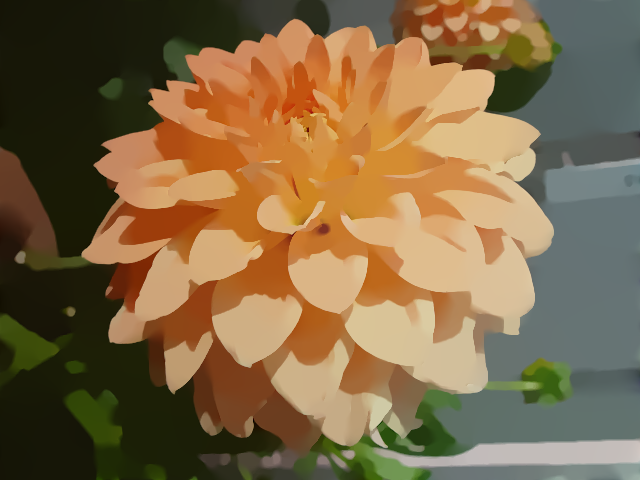

In [102]:
S

In [103]:
h[t] = 0

In [104]:
y = np.sum(np.power(h, 2) + np.power(v, 2))

In [105]:
np.power(h, 2).shape

(480, 640, 3)

In [106]:
S

array([[[  5.9425297,  20.019583 ,  20.755917 ],
        [  6.0542397,  20.192102 ,  20.842966 ],
        [  6.14256  ,  20.33105  ,  20.914463 ],
        ...,
        [107.669846 , 108.961555 ,  90.84153  ],
        [108.01291  , 109.42846  ,  91.10762  ],
        [108.39404  , 109.93427  ,  91.45025  ]],

       [[  5.9067087,  19.949068 ,  20.746122 ],
        [  6.087577 ,  20.208633 ,  20.877907 ],
        [  6.1455984,  20.310865 ,  20.923254 ],
        ...,
        [107.55492  , 108.825775 ,  90.7852   ],
        [107.88262  , 109.28602  ,  90.98953  ],
        [108.437614 , 110.05147  ,  91.21883  ]],

       [[  5.8903303,  19.886948 ,  20.761385 ],
        [  6.0702186,  20.171198 ,  20.871592 ],
        [  6.157002 ,  20.310608 ,  20.936243 ],
        ...,
        [107.466354 , 108.73385  ,  90.73801  ],
        [107.707825 , 109.0897   ,  90.866    ],
        [108.09659  , 109.64533  ,  90.97242  ]],

       ...,

       [[  5.993154 ,  20.153482 ,  20.767937 ],
        [  

In [33]:
h[t].shape

(462972,)

In [34]:
h.shape

(480, 640, 3)

In [61]:
v

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0

In [121]:
print(MTF)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [9.63820813e-05 9.63820813e-05 9.63820813e-05]
  [3.85519036e-04 3.85519036e-04 3.85519036e-04]
  ...
  [8.67382996e-04 8.67382996e-04 8.67382996e-04]
  [3.85519036e-04 3.85519036e-04 3.85519036e-04]
  [9.63820813e-05 9.63820813e-05 9.63820813e-05]]

 [[1.71344852e-04 1.71344852e-04 1.71344852e-04]
  [2.67726933e-04 2.67726933e-04 2.67726933e-04]
  [5.56863888e-04 5.56863888e-04 5.56863888e-04]
  ...
  [1.03872785e-03 1.03872785e-03 1.03872785e-03]
  [5.56863888e-04 5.56863888e-04 5.56863888e-04]
  [2.67726933e-04 2.67726933e-04 2.67726933e-04]]

 [[6.85350049e-04 6.85350049e-04 6.85350049e-04]
  [7.81732130e-04 7.81732130e-04 7.81732130e-04]
  [1.07086908e-03 1.07086908e-03 1.07086908e-03]
  ...
  [1.55273304e-03 1.55273304e-03 1.55273304e-03]
  [1.07086908e-03 1.07086908e-03 1.07086908e-03]
  [7.81732130e-04 7.81732130e-04 7.81732130e-04]]

 ...

 [[1.54192752e-03 1.54192752e-03 1.54192752e-03]
  [1.63830960e-03 1.63830960e-03 1.6383

In [122]:
MTF = np.power(np.abs(otfFx), 2) + np.power(np.abs(otfFy), 2)
MTF = np.tile(MTF[:, :, np.newaxis], (1, 1, D))

In [128]:
y = np.power(np.abs(otfFx), 2)

In [131]:
y[y<0]

array([], dtype=float64)

In [134]:
np.power(otfFx

array([[ 0.00000000e+00+0.j        , -4.81910407e-05+0.00981732j,
        -1.92759518e-04+0.01963369j, ..., -4.33691498e-04-0.02944817j,
        -1.92759518e-04-0.01963369j, -4.81910407e-05-0.00981732j],
       [ 0.00000000e+00+0.j        , -4.81910407e-05+0.00981732j,
        -1.92759518e-04+0.01963369j, ..., -4.33691498e-04-0.02944817j,
        -1.92759518e-04-0.01963369j, -4.81910407e-05-0.00981732j],
       [ 0.00000000e+00+0.j        , -4.81910407e-05+0.00981732j,
        -1.92759518e-04+0.01963369j, ..., -4.33691498e-04-0.02944817j,
        -1.92759518e-04-0.01963369j, -4.81910407e-05-0.00981732j],
       ...,
       [ 0.00000000e+00+0.j        , -4.81910407e-05+0.00981732j,
        -1.92759518e-04+0.01963369j, ..., -4.33691498e-04-0.02944817j,
        -1.92759518e-04-0.01963369j, -4.81910407e-05-0.00981732j],
       [ 0.00000000e+00+0.j        , -4.81910407e-05+0.00981732j,
        -1.92759518e-04+0.01963369j, ..., -4.33691498e-04-0.02944817j,
        -1.92759518e-04-0.01963369j